# A how-to for creating portfolios and simulating strategies.

In [1]:
from simulator import HistoricalSimulator
from strategies import SMAStrategy, VolTargetStrategy
from portfolio_maker import PortfolioMaker

In [2]:
from datetime import datetime, timedelta
import pickle

## *experimenting with `PortfolioMaker`*

In [3]:
pf = PortfolioMaker(0, relative_core_frac=False)

In [4]:
# add core assets
pf.add_ticker('VUG', .5, label='core'), # us, large-cap growth
pf.add_ticker('VTV', .05, label='core'), # us, large-cap growth
pf.add_ticker('VO', .15, label='core'), # us, mid-cap blend
pf.add_ticker('EFG', .15, label='core'), # intl, large-cap growth
pf.add_ticker('VBIIX', .15, label='core'), # us, highly rated interm. bonds
pf.add_ticker('ISHIX', 0, label='core'), # us, corp-grade bond

pf.assets

{'VUG': {'label': 'core', 'fraction': 0.5, 'shares': 0},
 'VTV': {'label': 'core', 'fraction': 0.05, 'shares': 0},
 'VO': {'label': 'core', 'fraction': 0.15, 'shares': 0},
 'EFG': {'label': 'core', 'fraction': 0.15, 'shares': 0},
 'VBIIX': {'label': 'core', 'fraction': 0.15, 'shares': 0},
 'ISHIX': {'label': 'core', 'fraction': 0, 'shares': 0}}

In [5]:
# add satellite assets

pf.add_ticker('SSO', label='satellite', in_market=True) # leveraged 2x to S&P 500
pf.add_ticker('TLT', label='satellite', in_market=True)
# long-term (20+ yr.) treasury bonds

pf.assets

{'VUG': {'label': 'core', 'fraction': 0.5, 'shares': 0},
 'VTV': {'label': 'core', 'fraction': 0.05, 'shares': 0},
 'VO': {'label': 'core', 'fraction': 0.15, 'shares': 0},
 'EFG': {'label': 'core', 'fraction': 0.15, 'shares': 0},
 'VBIIX': {'label': 'core', 'fraction': 0.15, 'shares': 0},
 'ISHIX': {'label': 'core', 'fraction': 0, 'shares': 0},
 'SSO': {'label': 'satellite', 'in_mkt': True, 'shares': 0},
 'TLT': {'label': 'satellite', 'in_mkt': True, 'shares': 0}}

In [6]:
# editing sat_frac will change core asset fractions when relative_core_frac==True
pf.relative_core_frac = True
pf.sat_frac = .4

pf.assets

core fractions reset relative to `sat_frac` value
core fractions adjusted relative to new `sat_frac` value


{'VUG': {'label': 'core', 'fraction': 0.3, 'shares': 0},
 'VTV': {'label': 'core', 'fraction': 0.03, 'shares': 0},
 'VO': {'label': 'core', 'fraction': 0.09, 'shares': 0},
 'EFG': {'label': 'core', 'fraction': 0.09, 'shares': 0},
 'VBIIX': {'label': 'core', 'fraction': 0.09, 'shares': 0},
 'ISHIX': {'label': 'core', 'fraction': 0.0, 'shares': 0},
 'SSO': {'label': 'satellite', 'in_mkt': True, 'shares': 0},
 'TLT': {'label': 'satellite', 'in_mkt': True, 'shares': 0}}

In [7]:
# if you want to change an existing core asset...
pf.edit_ticker_fraction('ISHIX', .05)

# if you want to change an existing satellite asset...
pf.edit_ticker_mkt_status('TLT', False)

pf.assets

{'VUG': {'label': 'core', 'fraction': 0.3, 'shares': 0},
 'VTV': {'label': 'core', 'fraction': 0.03, 'shares': 0},
 'VO': {'label': 'core', 'fraction': 0.09, 'shares': 0},
 'EFG': {'label': 'core', 'fraction': 0.09, 'shares': 0},
 'VBIIX': {'label': 'core', 'fraction': 0.09, 'shares': 0},
 'ISHIX': {'label': 'core', 'fraction': 0.03, 'shares': 0},
 'SSO': {'label': 'satellite', 'in_mkt': True, 'shares': 0},
 'TLT': {'label': 'satellite', 'in_mkt': False, 'shares': 0}}

In [8]:
# if no error is thrown from this method,
# this PortfolioMaker instance is ready for use in a simulation
# (error thrown here intentionally)
pf.check_assets()

core assets and target holding fraction(s):
30.00000% in VUG
3.00000% in VTV
9.00000% in VO
9.00000% in EFG
9.00000% in VBIIX
3.00000% in ISHIX
*** 63.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     SSO
out-of-market asset: TLT
*** 40.00000% in satellite overall ***
----------------


ValueError: Make sure core and satellite fractions add up to 1 (100%) before moving on to simulations.

In [9]:
# you can adjust fractions as shown above,
# but here i'll just remove an asset
pf.remove_ticker('VTV')

In [10]:
pf.check_assets()

core assets and target holding fraction(s):
30.00000% in VUG
9.00000% in VO
9.00000% in EFG
9.00000% in VBIIX
3.00000% in ISHIX
*** 60.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     SSO
out-of-market asset: TLT
*** 40.00000% in satellite overall ***
----------------
-----passed-----
----------------
benchmark assets and target holding fraction(s):
None.
----------------
-----passed-----



## *simulating a strategy*

I'll demonstrate a simulation with `SMAStrategy` (SMA for simple moving average). It places 100% of the portfolio's satellite portion in either the in-market or out-of-market asset.

It chooses between them by tracking some asset's price on rebalance days and comparing that to its 200 day simple moving average. It's a little more complicated than this, but roughly, if the tracked asset's price is 101% or more of its SMA, it buys into the in-market asset. Otherwise, it retreats into the out-of-market asset.

**As such, the `SMAStrategy` class has a special requirement that one of the tickers in `assets` has a key named `'track'` whose value is `True`.**

In [11]:
# i'll set SPY as the tracked asset and put it together with AGG
# to create a benchmark portfolio whose result you can compare to
# the core-satellite when the simulation is done
pf.add_ticker('SPY', .6, label='benchmark', track=True)
pf.add_ticker('AGG', .4, label='benchmark')

In [12]:
# check code for SMAStrategy() and HistoricalSimulator()
# to learn more about arguments; i'll write full descriptions soon
smas = SMAStrategy(pf, burn_in=200,
                   start_date=datetime(2007, 6, 1),
                   end_date=datetime(2015, 6, 1),
                   sat_rb_freq=6, tot_rb_freq=1, cash=1e4,
                   reinvest_dividends=True)

core assets and target holding fraction(s):
30.00000% in VUG
9.00000% in VO
9.00000% in EFG
9.00000% in VBIIX
3.00000% in ISHIX
*** 60.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     SSO
out-of-market asset: TLT
*** 40.00000% in satellite overall ***
----------------
-----passed-----
----------------
benchmark assets and target holding fraction(s):
60.00000% in SPY
40.00000% in AGG
*** 100.00000% in benchmark overall ***
----------------
-----passed-----

VUG from 2006-08-11 to 2015-06-01...
VO from 2006-08-11 to 2015-06-01...
EFG from 2006-08-11 to 2015-06-01...
VBIIX from 2006-08-11 to 2015-06-01...
ISHIX from 2006-08-11 to 2015-06-01...
SSO from 2006-08-11 to 2015-06-01...
TLT from 2006-08-11 to 2015-06-01...
SPY from 2006-08-11 to 2015-06-01...
AGG from 2006-08-11 to 2015-06-01...
sat [ 7  9 11  1  3] 
tot [5]
[ 5  6  7  8  9 10 11 12] 2007
[ 1  2  3  4  5  6  7  8  9 10 11 12] 2008
[ 1  2  3  4  5  6  7  8  9 10 11 

In [13]:
# assets is the main object -- it's basically PorfolioMaker's assets
# dict, but each ticker's dict adds new keys that contain a DataFrame
# with price data ('df') and how many shares of the asset you currently
# own ('shares')
for key, val in smas.assets.items():
    print(f"{key} asset dict's keys: {[k for k in val.keys()]}")

VUG asset dict's keys: ['label', 'fraction', 'shares', 'df']
VO asset dict's keys: ['label', 'fraction', 'shares', 'df']
EFG asset dict's keys: ['label', 'fraction', 'shares', 'df']
VBIIX asset dict's keys: ['label', 'fraction', 'shares', 'df']
ISHIX asset dict's keys: ['label', 'fraction', 'shares', 'df']
SSO asset dict's keys: ['label', 'in_mkt', 'shares', 'df']
TLT asset dict's keys: ['label', 'in_mkt', 'shares', 'df']
SPY asset dict's keys: ['label', 'fraction', 'shares', 'track', 'df']
AGG asset dict's keys: ['label', 'fraction', 'shares', 'df']


In [14]:
# recall that the first approximately `burn_in` indices (~200 in this example)
# come before the specified start date so there's enough data to calculate the
# `burn_in`-day simple moving average when the real start date arrives
smas.assets['VUG']['df'][smas.burn_in:].head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
200,2007-05-31 00:00:00+00:00,63.14,63.240,62.93,63.15,99900,53.521518,53.606285,53.343509,53.529995,99900,0.0,1.0
201,2007-06-01 00:00:00+00:00,63.32,63.520,63.21,63.28,85800,53.674098,53.843631,53.580855,53.640191,85800,0.0,1.0
202,2007-06-04 00:00:00+00:00,63.50,63.536,63.18,63.20,102400,53.826677,53.857193,53.555425,53.572378,102400,0.0,1.0
203,2007-06-05 00:00:00+00:00,63.25,63.390,63.00,63.34,137700,53.614761,53.733434,53.402845,53.691051,137700,0.0,1.0
204,2007-06-06 00:00:00+00:00,62.55,63.080,62.52,63.08,101200,53.021396,53.470658,52.995966,53.470658,101200,0.0,1.0


In [15]:
# you can only run once simulation per class instance,
# so it might be prudent to make a copy before doing so.
smas_base = pickle.loads(pickle.dumps(smas, -1))

In [16]:
# run the simulation (set verbose=True to see trades happening behind the scenes)
smas.begin_time_loop()

end date main portfolio value: $28,991.61
end date main portfolio shares: 
VUG: 84.2, VO: 21.3, EFG: 39.0, VBIIX: 262.1, ISHIX: 113.1, SSO: 175.8, TLT: 0.0

end date benchmark portfolio value: $21,131.48
end date benchmark portfolio shares: 
SPY: 66.4, AGG: 87.8


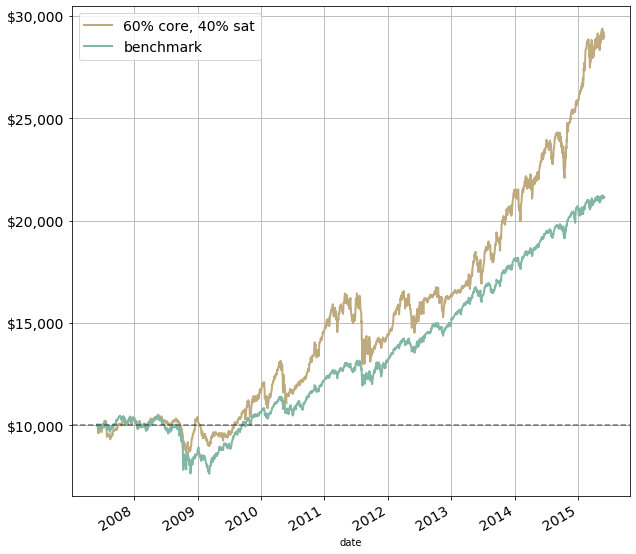

In [17]:
# plot the results, and compare to the more conservative benchmark
smas.plot_results()

**The idea from here is to try out different instances of `SMAStrategy` (or whichever strategy class) and vary assets, core/satellite allocations, dates, rebalance frequencies, etc. to see what would have led to the best historical results.**